# Prepare-a-VLAD

Prepare-a-VLAD helps you perform all steps to get neat and tidy VLADISLAV data suitable for deeper exploration and statistical analysis. We will end up with two datasets:
1. **Nosepoke events**, which are registered continuously while the device is powered on,
2. **Trials**, which contain various data pertaining to trials performed as part of experimental protocols, explained in detail later.

To prepare these two datasets, we will go through a few stages:
1. **Setup:** Define experiment parameters (location of the raw logs on the disk, animal labels, etc.),
2. **Data preparation:** Load and process raw data and split it according to various protocols used throughout the experiment (e.g. baseline, training, testing)
3. **Data exploration:** Perform exploration and diagnostics for some common issues (check timekeeping, check for broken devices, etc.)

These aren't strictly delimited, as we will tweak and perform more preparation steps based on diagnostics results.

Lastly, Prepare-a-VLAD contains code for drawing time-series heatmaps, originally developed for diagnostics, but quite useful for proper data exploration of cleaned datasets, too!

---

## Preparation

Import necessary libraries and set the working directory to the location of this script.

In [1]:
import warnings
from pathlib import Path
import json
import pandas as pd
import datetime
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import importlib.util
try:
    importlib.util.find_spec("google.colab")
except ModuleNotFoundError:
    IN_COLAB = False
else:
    IN_COLAB = True

import plotly.io as pio
# if figures don't display properly, you can try changing the renderer
# https://plotly.com/python/renderers/
if IN_COLAB:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook"
    #pio.renderers.default = "vscode"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets


In [ ]:
wd = Path(os.path.dirname(os.path.realpath('__file__'))).resolve()
#wd = Path("/home/davor/Documents/vladislav/"")

Set the experiment name. This is the name of the directory, that needs to be in the same location as this notebook, which contains raw VLADISLAV logs.

In [3]:
experiment = "mph"

Define animal labels.
1. Animal name/label (user-defined)
2. Animal group (user-defined)
3. VLADISLAV device ID (as recorded in the directory structure)

In [4]:
names_map = [
    ["zeleni1","CTR","vds_29"],
    ["zeleni2","CTR","vds_25"],
    ["zeleni3","CTR","vds_19"],
    ["zeleni4","CTR","vds_21"],
    ["zeleni5","CTR","vds_33"],
    ["zeleni6","CTR","vds_15"],
    ["zeleni7","CTR","vds_17"],
    ["zeleni8","CTR","vds_7"],
    ["zeleni9","CTR","vds_1"],
    ["zeleni10","CTR","vds_31"],
    ["crveni1","STZ","vds_5"],
    ["crveni2","STZ","vds_39"],
    ["crveni3","STZ","vds_35"],
    ["crveni4","STZ","vds_11"],
    ["crveni5","STZ","vds_9"],
    ["crveni6","STZ","vds_13"],
    ["crveni7","STZ","vds_23"],
    ["crveni8","STZ","vds_3"],
    ["crveni9","STZ","vds_27"],
    ["crveni10","STZ","vds_37"]
]

In [5]:
# Some useful dictionaries to e.g. map an animal name to its group or device
map_device_animal = {x[2]:x[0] for x in names_map} # e.g. key: vds_33, value: zeleni4
map_animal_device = {x[0]:x[2] for x in names_map} # e.g. key: zeleni4, value: vds_33
map_animal_group = {x[0]:x[1] for x in names_map} # e.g. key: zeleni4, value: CTR
devices = [x[2] for x in names_map]

---

## Load data

### Load trial data

Load trial data from raw text files into a Python list, and convert it into a Pandas dataframe. This dataframe is saved to a Parquet file called `{experiment}_trials.parquet` (in this case, `mph_trials.parquet`) inside the working directory.

We can set `skip_raw_trial_loading` to `True` if we have already performed this initial step and don't want to re-run it. The code will try to load the Parquet file instead.

In [6]:
skip_raw_trial_loading = True

In [7]:
if not skip_raw_trial_loading:
    trial_data = []
    devices = map_device_animal.keys()
    for device_id in devices:
        p = wd/experiment/device_id/"trials"
        logfiles = [ x for x in p.iterdir() if (not x.is_dir()) ]
        for logfile in logfiles:
            with open(logfile) as f:
                for l in f:
                    data_line = json.loads(l)
                    trial = data_line["message"]["trial"]
                    trial["device"] = device_id
                    trial["timestamp"] = data_line["timestamp"]
                    trial_data.append(trial)
    df = pd.DataFrame.from_records(trial_data)
    df = df.astype({"t_start":"datetime64[ns]","timestamp":"datetime64[ns]"})
    df.to_parquet(wd/f"{experiment}_trials.parquet")
else:
    df = pd.read_parquet(wd/f"{experiment}_trials.parquet")
df

,t_start,trial_n,iti,iti_extension,precue_correct,precue_reaction_time,delay_precue_cue,impulsive_nosepokes,correct,reaction_time,...,iti_max_touchread,iti_mean_touchread,precue_max_touchread,precue_mean_touchread,cue_max_touchread,cue_mean_touchread,reward_max_touchread,reward_mean_touchread,device,timestamp
0,2023-02-04 17:52:33.566110,1,5000,0,-1,-2,0,0,0,-1,...,26028,25720,0,0,25953,25728,0,0,vds_29,2023-02-04 17:52:48.611104
1,2023-02-04 17:52:48.610191,2,5009,0,-1,-2,0,0,0,-1,...,25943,25724,0,0,26022,25737,0,0,vds_29,2023-02-04 17:53:03.656334
2,2023-02-04 17:53:03.656113,3,5000,0,-1,-2,0,0,0,-1,...,25999,25736,0,0,26026,25713,0,0,vds_29,2023-02-04 17:53:18.698021
3,2023-02-04 17:53:18.700108,4,5000,0,-1,-2,0,0,0,-1,...,26040,25690,0,0,25973,25709,0,0,vds_29,2023-02-04 17:53:33.740024
4,2023-02-04 17:53:33.744108,5,5000,0,-1,-2,0,0,0,-1,...,26001,25712,0,0,26036,25696,0,0,vds_29,2023-02-04 17:53:48.784741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416312,2023-02-15 17:13:33.132945,21,5000,0,-1,-2,0,0,0,-1,...,17893,17759,0,0,17943,17771,0,0,vds_37,2023-02-15 17:13:53.215215
416313,2023-02-15 17:13:53.167211,22,5001,0,-1,-2,0,0,0,-1,...,17983,17780,0,0,17981,17772,0,0,vds_37,2023-02-15 17:14:13.239525
416314,2023-02-15 17:14:13.202950,23,5000,0,-1,-2,0,0,0,-1,...,17958,17791,0,0,17957,17763,0,0,vds_37,2023-02-15 17:14:33.293958
416315,2023-02-15 17:14:33.237947,24,5001,0,-1,-2,0,0,0,-1,...,17990,17788,0,0,17904,17751,0,0,vds_37,2023-02-15 17:14:53.315866


**Main parameters**

* `t_start` - Timestamp when the trial began. _(timestamp)_
* `timestamp` - Timestamp when the trial finished (technically, when the message containing trial data was received, which happens at the end of the trial). _(timestamp)_
* `device` - Device ID. _(string)_
* `trial_n` - Ordinal number of the trial in one session. _(integer)_
* `iti` - Actual measured inter-trial interval (ITI) in seconds. Defined by the protocol, and additionally extended by nosepokes made during the ITI. _(integer, seconds)_
* `iti_extension` - Number of times the ITI was extended by a nosepoke. _(integer)_
* `precue_correct` - Whether the precue was correct. `-1` is used as a placeholder value when the precue wasn't present, which is the case in training protocols. _(-1; 0; 1)_
* `precue_reaction_time` - Number of seconds elapsed since the last trial concluded to the start of the current trial, i.e. the precue response which initiated this trial. `-1` is used in case of a timeout within the duration of a session if a trial timeout is specified, `-2` is used when the trial terminates without a response to the precue, i.e. before the cue was presented, and this usually happens for the last trial of a session. _(integer, seconds; -1; -2)_
* `delay_precue_cue` - Time since the precue response until the presentation of the cue defined by the protocol - the preset duration of the precue-cue interval (PCCI). The actual time can be extended by nosepokes during the PCCI - 3000, 6000, or 12000 in this study. _(integer, seconds)_
* `precue_nosepoke_wait` - Actual measured duration of the PCCI, including any extensions by nosepokes in this interval - impulsive nosepokes (see `delay_precue_cue`). Defined by the protocol, and additionally extended by nosepokes made during the precue-cue interval (PCCI). _(integer, seconds)_
* `impulsive_nosepokes` - Number of nosepokes made during the PCCI (see `delay_precue_cue` and `precue_nosepoke_wait`). _(integer)_
* `correct` - Whether the animal responded to the cue by performing a nosepoke while the cue was presented. `-2` is used when the trial terminates without a response to the precue, i.e. before the cue was presented, and this usually happens for the last trial of a session. _(-2; 0; 1)_
* `reaction_time` - Time elapsed since the presentation of the cue until a response (nosepoke). `-1` is used if the cue was presented, but the animal failed to respond (timeout), `-2` is used if the trial terminated before the cue wasn't presented (e.g. the last trial of a session or a manually terminated session). _(integer, seconds; -1; -2)_

*NOTE:* The duration of each trial is a variable that might be useful, but was missing in the microcontroller code when this study was conducted. It can be calculated, though, as the difference between `timestamp` (when the message about a finished trial was received by the logging computer) and `t_start` (when the microcontroller recorded the start of the trial). We will do this later, after we check the timekeeping.

**Lick sensor parameters (in development)**

The following parameters are related to the partially-implemented lick sensor which monitors interaction with the water bottle when the reward was dispensed. Many are raw sensor values used for debugging and calibrating the sensor for future studies, and the number of parameters will ultimately be reduced. The data isn't yet analysed here due to a high sensor failure rate.
_Note:_ As before, for experimental values, `-2` is a placeholder value, which in this case means the reward (access to the water bottle) was not attained. 
_Note:_ Raw touch sensor values are suffixed with `_touchread` and are always measured to provide baseline sensor values when water bottle access was not permitted. These are 32-bit unsigned integers, with a range from 0 to 4,294,967,295.

* `licked` - Whether the bottle was licked when presented as a reward. _(-2; 0; 1)_
* `time_to_lick` - Time elapsed since the reward was presented until first contact.  _(integer, seconds; -2)_
* `total_lick_t` - Total time spent licking the bottle. _(integer, seconds; -2)_
* `iti_max_touchread` - Maximum value of the touch sensor recorded during the ITI. _(uint32)_
* `iti_mean_touchread` - Mean value of the touch sensor recorded during the ITI. _(uint32)_
* `precue_max_touchread` - Maximum value of the touch sensor recorded while the precue was presented. _(uint32)_
* `precue_mean_touchread` - Mean value of the touch sensor recorded while the precue was presented. _(uint32)_
* `cue_max_touchread` - Maximum value of the touch sensor recorded while the cue was presented. _(uint32)_
* `cue_mean_touchread` - Mean value of the touch sensor recorded while the cue was presented. _(uint32)_
* `reward_max_touchread` - Maximum value of the touch sensor recorded during the reward period. `0` if the reward wasn't obtained. _(uint32)_
* `reward_mean_touchread` - Mean value of the touch sensor recorded during the reward period. `0` if the reward wasn't obtained. _(uint32)_


We will now add columns containing the animal name and group.

In [8]:
df["animal"] = df["device"].apply(lambda x: map_device_animal[x])
df["group"] = df["animal"].apply(lambda x: map_animal_group[x])

We will stop here and load event data to look at the two together for diagnostics and exploration.

### Load nosepoke event data

First, we'll load the event data into a structured dataset. We're doing this at the start so we have the dataset at our disposal in later steps. This dataframe is saved to a Parquet file called `{experiment}_nosepokes.parquet` (in this case, `mph_nosepokes.parquet`) inside the working directory.

We can set `skip_raw_nosepoke_loading` to `True` if we have already performed this initial step and don't want to re-run it. The code will try to load the Parquet file instead.

In [9]:
skip_raw_nosepoke_loading = True

The following code loads the raw [JSON lines](https://jsonlines.org/) files into a Pandas dataframe.

NOTE: Events which indicate that the microcontroller turned on ("Booted!") and bottle lick events are also recorded, but are currently discarded.

In [10]:
if not skip_raw_nosepoke_loading:
    nosepokes_data = pd.DataFrame()
    tmpfile = wd/"_tmpfile.json"
    for device_id in tqdm(devices):
        nosepokes = []
        #event_data[device_id] = {}
        p = wd/experiment/device_id/"events"
        logfiles = [ x for x in p.iterdir() if (not x.is_dir()) ]
        with open(tmpfile, "w") as f_tmp:
            for logfile in logfiles:
                with open(logfile) as f:
                    for l in f:
                        if ("Booted!" not in l) and ("EVENT:BOTTLELICK" not in l):
                            f_tmp.write(l)
                        #event = "Booted!"
                    # else:
                #         data_line = json.loads(l)
                #         event = data_line["message"]["event"]
                #         #if event not in event_data[device]:
                #         #    event_data[device][event] = 1
                #         #else:
                #         #    event_data[device][event] += 1
                #         if event["event_name"] == "EVENT:NOSEPOKE":
                #             nosepokes.append([pd.to_datetime(data_line["timestamp"]), event["state"]])
        with open(tmpfile, "r") as f_tmp:
            nosepokes = pd.read_json(f_tmp, lines=True, encoding_errors="ignore")
            if not nosepokes.empty:
                timestamps = nosepokes["timestamp"].copy()
                nosepokes = pd.json_normalize(nosepokes["message"].to_list(), record_prefix="")
                nosepokes["msg_timestamp"] = timestamps.copy()
                del timestamps
                nosepokes.columns = [col.split(".")[-1] for col in nosepokes.columns]
                nosepokes["animal"] = map_device_animal[device_id]
                nosepokes_data = pd.concat([nosepokes_data, nosepokes], axis=0)
            del nosepokes
    tmpfile.unlink()
    # event_data = pd.DataFrame(event_data).T
    # event_data = event_data.reset_index(names="device")
    # event_data["animal"] = event_data["device"].apply(lambda x: map_device_animal[x])
    # event_data.to_parquet(wd/"event_data.parquet")
    nosepokes_data.to_parquet(wd/f"{experiment}_nosepokes.parquet")
else:
    nosepokes_data = pd.read_parquet(wd/f"{experiment}_nosepokes.parquet")
# Since we've filtered out nosepokes, "event_name" will always be "EVENT:NOSEPOKE" so we can remove the column
nosepokes_data = nosepokes_data.drop(columns=["event_name"])
nosepokes_data

,t_start,state,msg_timestamp,animal
index,,,,
0,2023-02-04T17:09:46.299571,INTVL:IDLE,2023-02-04 17:09:46.327098,zeleni1
1,2023-02-04T18:24:50.852255,POINT:CUE,2023-02-04 18:24:50.885239,zeleni1
2,2023-02-04T19:01:02.982302,POINT:CUE,2023-02-04 19:01:03.044178,zeleni1
3,2023-02-04T20:24:53.922338,POINT:CUE,2023-02-04 20:24:54.034800,zeleni1
4,2023-02-04T20:25:30.762257,POINT:CUE,2023-02-04 20:25:30.875863,zeleni1
...,...,...,...,...
173269,2023-03-29T03:08:23.808478,INTVL:IDLE,2023-03-29 04:08:23.848315,crveni9
173270,2023-03-29T03:29:31.898476,INTVL:IDLE,2023-03-29 04:29:31.961806,crveni9
173271,2023-03-29T03:29:32.898551,INTVL:IDLE,2023-03-29 04:29:32.954395,crveni9


### Load status data

Finally, there's the status logs, from which we load the information about the currently loaded phase.

- Phase 1 and 2: Training, where 1 is easier and 2 is more difficult (shorter cue presentation, longer ITI, shorter reward)
- Phase 4 and 5: Test, where 5 is easier and 4 is more difficult (shorter cue presentation and shorter reward)

Phase 3 is unused. More information can be found in the Arduino protocol configuration.

In [11]:
skip_raw_status_loading = True

In [12]:
if not skip_raw_status_loading:
    status_data = pd.DataFrame()
    for device_id in tqdm(devices):
        p = wd/experiment/device_id/"status"
        logfiles = [ x for x in p.iterdir() if (not x.is_dir()) ]
        for logfile in logfiles:
            with open(logfile) as f:
                status_msgs = pd.read_json(f, lines=True, encoding_errors="ignore")
                if not status_msgs.empty:
                    status_msgs["message"] = pd.json_normalize(status_msgs["message"])
                    status_msgs = status_msgs.loc[status_msgs["message"].str.contains("Successfully set phase")]
                    status_msgs["animal"] = map_device_animal[device_id]
                    status_data = pd.concat([status_data, status_msgs], axis=0)

    status_data.to_parquet(wd/f"{experiment}_phaseset.parquet")
else:
    status_data = pd.read_parquet(wd/f"{experiment}_phaseset.parquet")
status_data["message"] = status_data["message"].str.split("Successfully set phase ", expand=True)[1].str.split(". ", regex=False, expand=True)[0]
status_data

,timestamp,message,animal
index,,,
0,2023-02-04 17:40:02.967419,2,zeleni1
5,2023-02-04 17:51:19.982171,2,zeleni1
1,2023-02-15 17:05:57.509704,1,zeleni1
8,2023-02-15 17:16:16.423252,1,zeleni1
19,2023-02-16 19:03:30.398042,2,zeleni1
...,...,...,...
75,2023-03-15 17:55:26.165523,4,crveni9
76,2023-03-15 17:58:22.981960,4,crveni9
77,2023-03-15 17:58:47.964246,4,crveni9


---

## Experimental notes

Before we dive into the data, let's check the experimental notes for details:

- During the training period:
    - the devices were engaged from 19:00 to 01:00
    - an easier protocol was used from 15th Feb to 18th Feb
    - a more difficult protocol was used from 19th Feb to 28th Feb

- During the testing period:
    - the devices were engaged from 19:00 to 23:00
    - an easier protocol was used from 1st Mar to 10th Mar
    - a more difficult protocol was used from 11th Mar to 28th Mar (sacrifice on 29th Mar)
    - _NOTE:_ Due to the duration of out-of-cage behavioural testing, VLADISLAV protocol was shifted a 20:00-00:00 schedule on 26th March.

- Out-of-cage behavioural testing was performed during the day, before in-cage VLADISLAV testing, on dates:
    1. 21st Feb - 26th Feb
    2. 7th Mar - 12th Mar
    3. 20th Mar - 26th Mar



We'll now add this information to the dataset.


In [13]:
df["protocol"] = None

df = df.loc[
    (df["t_start"] > pd.to_datetime("2023-02-15T12:00:00")) &
    (df["t_start"] < pd.to_datetime("2023-03-29T12:00:00"))
].copy()
#df.loc[(df["t_start"] < pd.to_datetime("2023-02-15T12:00:00")),
#       "protocol"] = "training"
#df.loc[(df["t_start"] < pd.to_datetime("2023-02-15T12:00:00")),
#       "difficulty"] = "difficult"

df.loc[(df["t_start"] > pd.to_datetime("2023-02-15T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-03-01T12:00:00")),
       "protocol"] = "training"
df.loc[(df["t_start"] > pd.to_datetime("2023-02-15T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-02-19T12:00:00")),
       "difficulty"] = "easy"
df.loc[(df["t_start"] > pd.to_datetime("2023-02-19T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-03-01T12:00:00")),
       "difficulty"] = "difficult"

df.loc[(df["t_start"] > pd.to_datetime("2023-03-01T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-03-29T12:00:00")),
       "protocol"] = "test"
df.loc[(df["t_start"] > pd.to_datetime("2023-03-01T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-03-11T12:00:00")),
       "difficulty"] = "easy"
df.loc[(df["t_start"] > pd.to_datetime("2023-03-11T12:00:00")) &
       (df["t_start"] < pd.to_datetime("2023-03-29T12:00:00")),
       "difficulty"] = "difficult"


In [14]:
df["bhv"] = pd.NA

df.loc[((df["t_start"] > pd.to_datetime("2023-02-21T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-22T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-07T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-08T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-20T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-21T12:00:00"))),
       "bhv"] = "OF"

df.loc[((df["t_start"] > pd.to_datetime("2023-02-25T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-26T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-10T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-11T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-22T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-23T12:00:00"))),
       "bhv"] = "SOCIAL"

df.loc[((df["t_start"] > pd.to_datetime("2023-03-23T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-24T12:00:00"))),
       "bhv"] = "PAV1"
df.loc[((df["t_start"] > pd.to_datetime("2023-03-24T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-25T12:00:00"))),
       "bhv"] = "PAV2"

df.loc[((df["t_start"] > pd.to_datetime("2023-02-26T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-27T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-05T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-06T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-12T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-13T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-19T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-20T12:00:00"))) |
       ((df["t_start"] > pd.to_datetime("2023-03-26T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-27T12:00:00"))),
       "bhv"] = "STARTLE"

df.loc[((df["t_start"] > pd.to_datetime("2023-02-22T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-23T12:00:00"))) &
       (df["animal"].str.endswith(("1", "2", "3", "4"))),
       "bhv"] = "NOR"
df.loc[((df["t_start"] > pd.to_datetime("2023-02-23T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-24T12:00:00"))) &
       (df["animal"].str.endswith(("5", "6", "7", "8", "9"))),
       "bhv"] = "NOR"
df.loc[((df["t_start"] > pd.to_datetime("2023-02-24T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-02-25T12:00:00"))) &
       (df["animal"].str.endswith(("10"))),
       "bhv"] = "NOR"

df.loc[((df["t_start"] > pd.to_datetime("2023-03-08T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-09T12:00:00"))) &
       (df["animal"].str.endswith(("1", "2", "3", "4"))),
       "bhv"] = "NOR"
df.loc[((df["t_start"] > pd.to_datetime("2023-03-09T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-10T12:00:00"))) &
       (df["animal"].str.endswith(("5", "6", "7", "8", "9", "10"))),
       "bhv"] = "NOR"

df.loc[((df["t_start"] > pd.to_datetime("2023-03-21T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-22T12:00:00"))) &
       (df["animal"].str.endswith(("1", "2", "3", "4", "5", "6", "7", "8"))),
       "bhv"] = "NOR"
df.loc[((df["t_start"] > pd.to_datetime("2023-03-22T12:00:00")) & (df["t_start"] < pd.to_datetime("2023-03-23T12:00:00"))) &
       (df["animal"].str.endswith(("9", "10"))),
       "bhv"] = "NOR"

df["bhv_performed"] = df["bhv"].notna().copy()

In [15]:
names_map

[['zeleni1', 'CTR', 'vds_29'],
 ['zeleni2', 'CTR', 'vds_25'],
 ['zeleni3', 'CTR', 'vds_19'],
 ['zeleni4', 'CTR', 'vds_21'],
 ['zeleni5', 'CTR', 'vds_33'],
 ['zeleni6', 'CTR', 'vds_15'],
 ['zeleni7', 'CTR', 'vds_17'],
 ['zeleni8', 'CTR', 'vds_7'],
 ['zeleni9', 'CTR', 'vds_1'],
 ['zeleni10', 'CTR', 'vds_31'],
 ['crveni1', 'STZ', 'vds_5'],
 ['crveni2', 'STZ', 'vds_39'],
 ['crveni3', 'STZ', 'vds_35'],
 ['crveni4', 'STZ', 'vds_11'],
 ['crveni5', 'STZ', 'vds_9'],
 ['crveni6', 'STZ', 'vds_13'],
 ['crveni7', 'STZ', 'vds_23'],
 ['crveni8', 'STZ', 'vds_3'],
 ['crveni9', 'STZ', 'vds_27'],
 ['crveni10', 'STZ', 'vds_37']]


Additionally, we have noted device with failures (either continuous or sporadic) in devices:

- `vds_19`, `vds_5`, `vds_37`, `vds_13`, `vds_15`, `vds_1`

### Cleaning and setting experimental variables

In this section, the actual experimental setup comes into play, related to our particular experiment and how we've conducted it.

We have three main periods during the experiment:
1. Training before the application of streptozotocin/sporadic Alzheimer's disease model induction,
2. Training after model induction, which began after a pause to allow for post-procedure recovery,
3. Testing, which introduces the precue and rodent-initiated trials.

We will now split the three periods. First streptozotocin application occurred on 4th Feb 2023, so the first period came before this time.

Then, the animals were given time to recover from the procedure, and the training protocol was reinitated on 15th Feb 2023. The testing protocol began on 1st March 2023.

*NOTE:* Baseline training (period 1) was fairly short, while training after model induction (period 2) and testing (period 3) each started off with an easier protocol, which was then switched to a more difficult one. Changes involve a shorter reward time, a longer time between trials (ITI) for training protocols, and a shorter cue presentation duration for testing protocols. The more difficult protocol in the training period was introduced on 18th Feb 2023, and on 11th March 2023 in the testing period.

*NOTE:* In the data, some devices will note training being performed after 1st March. These devices were malfunctioning at some point during the experiment - repairs were carried out and a training phase was reinitiated sometime after 1st March as these data could be informative for a VLADISLAV pilot study, however, they should not be included in the analysis as the data and the context aren't comparable with the rest of the animals. However, we generally can get these trials too, with the `precue_correct` column, as it will be `-1` when there was no precue specified in the protocol, i.e. during training.

To get more impulsivity data, we implemented a paradigm similar to the out-of-cage test _Variable Delay-to-Signal_ (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3806225/), wherein the duration of the precue-cue interval changes throughout each session/testing night. Each session is four hours long and split into three parts:

1. Fixed precue-cue delay of 3 seconds (first of the session - 48 minutes)
2. Random precue-cue delay of either 6 or 12 seconds (2nd, 3rd and 4th fifth of the session - 2 hours 24 minutes)
3. Fixed precue-cue delay of 3 seconds (last fifth of the session - 48 minutes)

We will add this information into our testing period dataset.

In [16]:
# Trials from the beginning and the end of the session both have a precue-cue delay of 3 seconds/3000 milliseconds
# Since each session starts at 19:00, and the first part of the session ends before 20:00, we use
# a cutoff of 21:00 to separate trials that have a 3 s precue-cue delay from the beginning from those at the end.
df.loc[ (df["protocol"] == "test") &
        ((df["delay_precue_cue"] == 3000) &
         (df["t_start"].dt.hour < 21)),
        "session_part" ] = 1
df.loc[ (df["protocol"] == "test") &
        ((df["delay_precue_cue"] == 3000) &
         (df["t_start"].dt.hour > 21)),
        "session_part"] = 3
# Trials with precue-cue delays of 6 and 12 seconds always belong to the second part of the session.
df.loc[ (df["protocol"] == "test") &
        ((df["delay_precue_cue"] == 6000) |
         (df["delay_precue_cue"] == 12000)),
        "session_part"] = 2

Next, we will add a numeric column which specifies the level of completion of each trial with three levels: `0`, `1`, and `2`.

In the training phase, trials are started automatically and only one interaction is required to obtain the reward, so training phase trials will have two levels: `0` if there was no response to the cue, and `2` if the animal responded to the cue with a nosepoke and the reward was successfully obtained.

In testing trials, a trial data entry is created whenever a precue signal is presented, which means even sessions with no interaction from the animal will have one trial with a failed precue response (registering a `0` in the `precue_correct` column and a `-2` in the `correct` column). This will usually also be the last trial of each session, which gets terminated on a schedule or manually while the precue is shown, and a `0` will be assigned to these trials. If the reward is obtained by responding to both the precue and the cue with a nosepoke response to each, a `2` will be assigned. However, if there is only a response to the precue signal and no response to the cue, the reward is not obtained and the trial counts as abandoned - these trials will be assigned a `1`.

In summary, the three levels are as follows:

* `0` - No animal interaction in the trial,
* `1` - Abandoned trial (testing trials only),
* `2` - Trial successfully completed and reward obtained.

In [17]:
df.loc[(df["correct"] == -2), "completion"] = 0
df.loc[(df["correct"] ==  0), "completion"] = 1
df.loc[(df["correct"] ==  1), "completion"] = 2

We will replace numbers which signify no interaction, as we'll be binning the data by summing the number of started trials, correctly solved trials etc. We can also remove all rows where `precue_correct` is `0` as these are just placeholder messages for the end of the session.

In [18]:
df = df.drop(
    df.loc[
        (df["precue_correct"].isin([0, -1])) &
        (df["protocol"] == "test")
    ].index
)
df["precue_correct"] = df["precue_correct"].replace(-2, pd.NA)
df["precue_correct"] = df["precue_correct"].replace(-1, pd.NA)
df["precue_reaction_time"] = df["precue_reaction_time"].replace(-2, pd.NA)
df["precue_reaction_time"] = df["precue_reaction_time"].replace(-1, pd.NA)
df["correct"] = df["correct"].replace(-2, pd.NA)
df["reaction_time"] = df["reaction_time"].replace(-2, pd.NA)
df["reaction_time"] = df["reaction_time"].replace(-1, pd.NA)
#df_test_exploratory = df_test[["t_start", "animal", "group", "precue_correct", "correct", "impulsive_nosepokes", "reaction_time"]]
#test_exp_responses = df_test_exp[["t_start", "animal", "group", "precue_correct"]].set_index("t_start").groupby("animal").resample(pd.to_timedelta("1 hour")).agg({"precue_correct": "sum", "group": "last"}) 

A `day` column with the day number as an ordinal variable will also come in handy later for statistical analysis. We will center the time to noon so everything that comes before noon "belongs" to the previous day, and everything after to the following one.

In [19]:
start_point = pd.to_datetime("2023-02-14T12:00:00")
df["day"] = np.floor((df["t_start"] - start_point)/pd.to_timedelta("1 day"))
df


,t_start,trial_n,iti,iti_extension,precue_correct,precue_reaction_time,delay_precue_cue,impulsive_nosepokes,correct,reaction_time,...,timestamp,animal,group,protocol,difficulty,bhv,bhv_performed,session_part,completion,day
9370,2023-02-15 19:00:04.197601,1,10000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 19:00:44.300503,zeleni1,CTR,training,easy,<NA>,False,NaN,1.0,1.0
9371,2023-02-15 19:00:44.234604,2,10000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 19:01:24.336423,zeleni1,CTR,training,easy,<NA>,False,NaN,1.0,1.0
9372,2023-02-15 19:01:24.268875,3,10000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 19:02:04.368577,zeleni1,CTR,training,easy,<NA>,False,NaN,1.0,1.0
9373,2023-02-15 19:02:04.304603,4,10000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 19:02:44.401882,zeleni1,CTR,training,easy,<NA>,False,NaN,1.0,1.0
9374,2023-02-15 19:02:44.338871,5,10001,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 19:03:24.435649,zeleni1,CTR,training,easy,<NA>,False,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416312,2023-02-15 17:13:33.132945,21,5000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 17:13:53.215215,crveni10,STZ,training,easy,<NA>,False,NaN,1.0,1.0
416313,2023-02-15 17:13:53.167211,22,5001,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 17:14:13.239525,crveni10,STZ,training,easy,<NA>,False,NaN,1.0,1.0
416314,2023-02-15 17:14:13.202950,23,5000,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 17:14:33.293958,crveni10,STZ,training,easy,<NA>,False,NaN,1.0,1.0
416315,2023-02-15 17:14:33.237947,24,5001,0,<NA>,<NA>,0,0,0,<NA>,...,2023-02-15 17:14:53.315866,crveni10,STZ,training,easy,<NA>,False,NaN,1.0,1.0


We will add a `reliability` column, which will be either `0` or `1`. Initially, we'll set the entire column to `1`, and then flip some time periods for some or all animals to `0` if exploratory analysis shows e.g. device failures. Later, it will be easy to use this column for filtering.

In [20]:
df["reliability"] = 1

We can also immediately set `reliability` to `0` for devices listed as malfunctioning in our experimental notes.

In [21]:
faulty_devices = ["vds_19", "vds_5", "vds_37", "vds_13", "vds_15", "vds_1"]
df.loc[
    df["device"].isin(faulty_devices),
    "reliability"] = 0

Finally, we will reorder the columns and exclude the lick-related columns in one command.

In [22]:
column_order = [ 
    ### Timekeeping
    "t_start", "timestamp", "day",
    ### Identifiers
    "animal", "group", "device",
    ### Out-of-cage behaviour testing variables
    "bhv", "bhv_performed",
    ### Other metadata we've just added
    "reliability", "completion", "protocol", "difficulty", "session_part",
    ### Measured experimental variables
    "trial_n", "iti", "iti_extension", "precue_correct", "precue_reaction_time",
    "delay_precue_cue","impulsive_nosepokes", "correct", "reaction_time",
    "licked", "time_to_lick", "total_lick_t", "precue_nosepoke_wait",
    ### Touchread variables (work in progress, will be used for further VLADISLAV development)
    "iti_max_touchread", "iti_mean_touchread", "precue_max_touchread",
    "precue_mean_touchread", "cue_max_touchread", "cue_mean_touchread",
    "reward_max_touchread", "reward_mean_touchread"
]

unordered_columns = [col for col in df.columns if col not in column_order]
if unordered_columns:
    warnings.warn(f"Columns {unordered_columns} not specified in column order. Appending them to the end.")
df = df.reindex(columns=(column_order + unordered_columns)).copy()

### Timekeeping diagnostics

As stated above, all data is recorded with two timestamps: one logged by the microcontroller performing the testing (`t_start`), and the other by the logging computer when it receives the message (`timestamp`, relabeled as `msg_timestamp` in this data). Since nosepoke events are transmitted as soon as they occur, we expect the difference to be negligible (on the order of 50-150 milliseconds).  Checking this difference is a good way to check timekeeping, and, generally, the computer (`timestamp`) should be correct. 

Of course, messed up timekeeping is quite unexpected, but an edge case happened during our experiment: a DST switch from winter (CET) to summer (CEST) time, which the microcontrollers didn't handle graciously. We've implemented a fix in the microcontroller code, but it's good to show how to clean the data in cases such as these _post facto_ using redundant timekeeping (from both the microcontroller and the logging computer sides).

<Axes: >

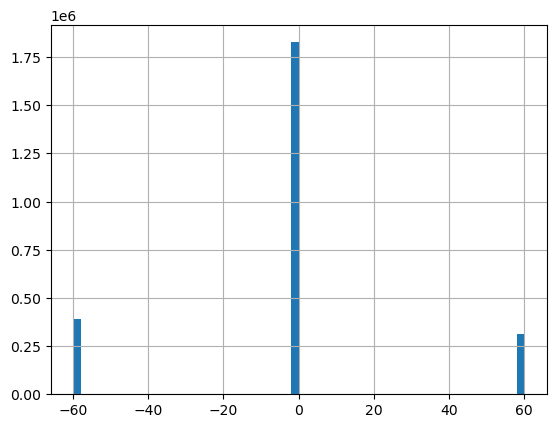

In [23]:
nosepokes_data = nosepokes_data.astype({"t_start": "datetime64[ns]",
                                        "msg_timestamp": "datetime64[ns]"})
nosepokes_data["t_delta"] = nosepokes_data["msg_timestamp"]-nosepokes_data["t_start"]
(nosepokes_data["t_delta"]/pd.Timedelta("1 minute")).hist(bins=60)

When we calculate the difference in time recorded on the microcontroller vs. that recorded on the computer, it seems most of our values are around 0, which is valid, and some are shifted 1 hour in either direction.

In [24]:
one_hour_plus = nosepokes_data.loc[nosepokes_data["t_delta"] > pd.Timedelta("50 minutes")]

In [25]:
def get_consecutive_indexes(g):
    
    ind = pd.Series(g.index)
    # this will give a series where the first group of consecutive indexes become 1, the second become 2 etc.
    # for example, [1, 2, 3, 7, 8, 9] will become [1, 1, 1, 2, 2, 2]
    ind_groups = ind.diff().ne(1).cumsum()
    # this will give a 1 whenever there's a break in consecutiveness,
    # for example, [1, 2, 3, 7, 8, 9] will become [1, 0, 0, 1, 0, 0]
    ind_breaks = (ind_groups - ind_groups.shift()).fillna(1).astype(bool)
    # this gives the actual index numbers where the breaks occur
    ind_breaks_values = list(ind.loc[ind_breaks])
    ind_breaks_values.append(int(ind.iloc[-1]))
    consecutive_indexes = []
    for i in range(len(ind_breaks_values)-1):
        consecutive_indexes.append((ind_breaks_values[i], ind_breaks_values[i+1]))
    return consecutive_indexes


In [26]:
shifted_time_ranges = {}
minimum_timestamp = None
maximum_timestamp = None
for animal_id in nosepokes_data["animal"].unique():
    g = one_hour_plus.loc[one_hour_plus["animal"] == animal_id]
    if not g.empty:
        consecutive_indexes = get_consecutive_indexes(g)
        for t in consecutive_indexes:
            shifted_time_ranges[animal_id] = {
                "timestamps": (g.loc[t[0], "t_start"], g.loc[t[1], "t_start"]),
                "deltas": (g.loc[t[0], "t_delta"], g.loc[t[1], "t_delta"])
            }
            if not minimum_timestamp:
                minimum_timestamp = shifted_time_ranges[animal_id]["timestamps"][0]
            else:
                minimum_timestamp = min(minimum_timestamp, shifted_time_ranges[animal_id]["timestamps"][0])
            if not maximum_timestamp:
                maximum_timestamp = shifted_time_ranges[animal_id]["timestamps"][1]
            else:
                maximum_timestamp = max(maximum_timestamp, shifted_time_ranges[animal_id]["timestamps"][1])
shifted_time_ranges

{'zeleni1': {'timestamps': (Timestamp('2023-03-26 02:02:50.584565'),
   Timestamp('2023-03-29 07:51:58.098352')),
  'deltas': (Timedelta('0 days 01:00:00.516781'),
   Timedelta('0 days 01:00:00.114277'))},
 'zeleni2': {'timestamps': (Timestamp('2023-03-26 16:27:03.585182'),
   Timestamp('2023-03-29 03:20:19.090730')),
  'deltas': (Timedelta('0 days 01:00:00.075821'),
   Timedelta('0 days 01:00:00.030225'))},
 'zeleni4': {'timestamps': (Timestamp('2023-03-26 21:09:54.733067'),
   Timestamp('2023-03-28 22:59:20.961533')),
  'deltas': (Timedelta('0 days 01:00:00.109458'),
   Timedelta('0 days 01:00:00.077869'))},
 'zeleni5': {'timestamps': (Timestamp('2023-03-26 02:54:43.324730'),
   Timestamp('2023-03-29 07:41:56.816974')),
  'deltas': (Timedelta('0 days 01:00:00.075818'),
   Timedelta('0 days 01:00:00.056850'))},
 'zeleni6': {'timestamps': (Timestamp('2023-03-26 08:30:34.443138'),
   Timestamp('2023-03-29 03:22:18.701987')),
  'deltas': (Timedelta('0 days 01:00:00.065176'),
   Timedelta

Get a summary of the number of shifted ranges per animal:

In [27]:
number_of_shifted_ranges = [len(x["timestamps"])/2 for x in shifted_time_ranges.values()]
number_of_shifted_ranges

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

So it seems that we only have one contiguous set of readings that have their `t_start` shifted backward by one hour relative to `timestamp`. As the times roughly match among all animals, we can find the global minimum and maximum (first and last shifted timestamp) to pinpoint the values we need to shift in the events dataframe:

In [28]:
minimum_timestamp, maximum_timestamp

(Timestamp('2023-03-26 02:00:00.024729'),
 Timestamp('2023-03-29 10:11:00.335726'))

Shifted times seem to start around 2 AM on 26th March and go on until the end of the experiment. Let's check the full `df`:

In [29]:
df.loc[df["t_start"] > pd.Timestamp('2023-03-26 01:59:00'), ["t_start", "timestamp"]]

,t_start,timestamp
21212,2023-03-26 19:00:04.006872,2023-03-26 20:01:27.835966
21213,2023-03-26 19:01:27.777670,2023-03-26 20:07:18.287185
21214,2023-03-26 19:07:18.235874,2023-03-26 20:08:58.267016
21215,2023-03-26 19:08:58.215873,2023-03-26 20:10:10.527860
21216,2023-03-26 19:10:10.465876,2023-03-26 20:10:58.065396
...,...,...
416286,2023-03-28 22:52:40.546178,2023-03-28 23:54:56.561835
416287,2023-03-28 22:54:56.566123,2023-03-28 23:56:39.332164
416288,2023-03-28 22:56:39.318125,2023-03-28 23:57:02.664380
416289,2023-03-28 22:57:02.657126,2023-03-28 23:57:49.002411


...And, indeed, all `t_start` values from 25th March 2023 at 19:00, when the protocol began, until the end of the experiment show the shift. This is how we discovered which values to correct back in the early parts of the notebook (when we first generated the `df_uncorrected` object). We will store these ranges in a `t_start_corrections` list, which will contain two-item tuples: 1. range of values which to shift, 2. how much to shift.

In [30]:
t_start_corrections = [
    ((pd.Timestamp('2023-03-26 01:59:00'), "end"),
     pd.Timedelta("1 hour"))
]

...And do it all over again for +1 hour shift, or 1 hour backwards shift of `t_start` relative to `timestamp`:

In [31]:
one_hour_minus = nosepokes_data.loc[nosepokes_data["t_delta"] < pd.Timedelta("-50 minutes")]
shifted_time_ranges = {}
minimum_timestamp = None
maximum_timestamp = None
for animal_id in nosepokes_data["animal"].unique():
    g = one_hour_minus.loc[one_hour_minus["animal"] == animal_id]
    if not g.empty:
        consecutive_indexes = get_consecutive_indexes(g)
        for t in consecutive_indexes:
            shifted_time_ranges[animal_id] = {
                "timestamps": (g.loc[t[0], "t_start"], g.loc[t[1], "t_start"]),
                "deltas": (g.loc[t[0], "t_delta"], g.loc[t[1], "t_delta"])
            }
            if not minimum_timestamp:
                minimum_timestamp = shifted_time_ranges[animal_id]["timestamps"][0]
            else:
                minimum_timestamp = min(minimum_timestamp, shifted_time_ranges[animal_id]["timestamps"][0])
            if not maximum_timestamp:
                maximum_timestamp = shifted_time_ranges[animal_id]["timestamps"][1]
            else:
                maximum_timestamp = max(maximum_timestamp, shifted_time_ranges[animal_id]["timestamps"][1])
shifted_time_ranges

{'zeleni1': {'timestamps': (Timestamp('2023-03-12 03:02:24.802462'),
   Timestamp('2023-03-15 18:41:36.884242')),
  'deltas': (Timedelta('-1 days +23:00:00.384444'),
   Timedelta('-1 days +23:00:00.038060'))},
 'zeleni2': {'timestamps': (Timestamp('2023-03-12 05:33:46.677185'),
   Timestamp('2023-03-15 09:20:25.258879')),
  'deltas': (Timedelta('-1 days +23:00:00.060185'),
   Timedelta('-1 days +23:00:00.035875'))},
 'zeleni4': {'timestamps': (Timestamp('2023-03-12 19:28:16.760118'),
   Timestamp('2023-03-14 23:43:22.938248')),
  'deltas': (Timedelta('-1 days +23:00:00.042623'),
   Timedelta('-1 days +23:00:00.025319'))},
 'zeleni5': {'timestamps': (Timestamp('2023-03-12 19:35:07.393175'),
   Timestamp('2023-03-15 08:49:17.272872')),
  'deltas': (Timedelta('-1 days +23:00:00.027119'),
   Timedelta('-1 days +23:00:00.118784'))},
 'zeleni6': {'timestamps': (Timestamp('2023-03-14 23:43:44.081881'),
   Timestamp('2023-03-14 23:43:44.081881')),
  'deltas': (Timedelta('-1 days +23:00:00.0492

In [32]:
number_of_shifted_ranges = [len(x["timestamps"])/2 for x in shifted_time_ranges.values()]
number_of_shifted_ranges

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [33]:
minimum_timestamp, maximum_timestamp

(Timestamp('2023-03-12 03:00:00.760051'),
 Timestamp('2023-03-15 18:41:36.884242'))

In [34]:
df.loc[(df["t_start"] > pd.Timestamp('2023-03-12 02:59:00')) &
       (df["t_start"] < pd.Timestamp('2023-03-15 19:01:00')),
       ["t_start", "timestamp"]]

,t_start,timestamp
20279,2023-03-12 19:33:26.376280,2023-03-12 18:34:17.435003
20282,2023-03-12 20:18:57.607131,2023-03-12 19:19:44.202034
20283,2023-03-12 20:20:13.608889,2023-03-12 19:20:50.232371
20284,2023-03-12 20:20:50.241892,2023-03-12 19:21:06.216178
20285,2023-03-12 20:21:06.221891,2023-03-12 19:21:53.224415
...,...,...
415427,2023-03-14 23:54:37.151905,2023-03-14 22:55:37.611809
415428,2023-03-14 23:55:37.591905,2023-03-14 22:57:34.177465
415430,2023-03-15 19:00:03.181732,2023-03-15 19:00:18.915308
415431,2023-03-15 19:00:18.884735,2023-03-15 19:00:53.319107


In [35]:
t_start_corrections.append(
    (
        ((pd.Timestamp('2023-03-12 02:59:00'), pd.Timestamp('2023-03-15 18:59:00'))),
        pd.Timedelta("-1 hour")
    )
)

In [36]:
for shift_range, shift_delta in t_start_corrections:
    shift_range = list(shift_range)
    if shift_range[0] == "start":
        shift_range[0] = df["t_start"].min()
    if shift_range[1] == "end":
        shift_range[1] = df["t_start"].max()
    df.loc[(df["t_start"] >= shift_range[0]) & (df["t_start"] <= shift_range[1]), "t_start"] += shift_delta
    nosepokes_data.loc[(nosepokes_data["t_start"] >= shift_range[0]) & (nosepokes_data["t_start"] <= shift_range[1]), "t_start"] += shift_delta

<Axes: >

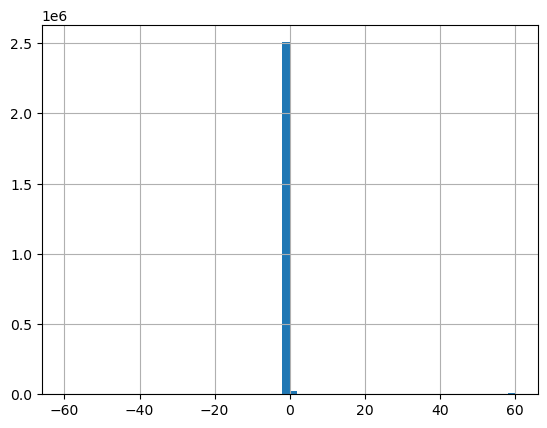

In [37]:
nosepokes_data["t_delta"] = nosepokes_data["msg_timestamp"]-nosepokes_data["t_start"]
(nosepokes_data["t_delta"]/pd.Timedelta("1 minute")).hist(bins=60)

<Axes: >

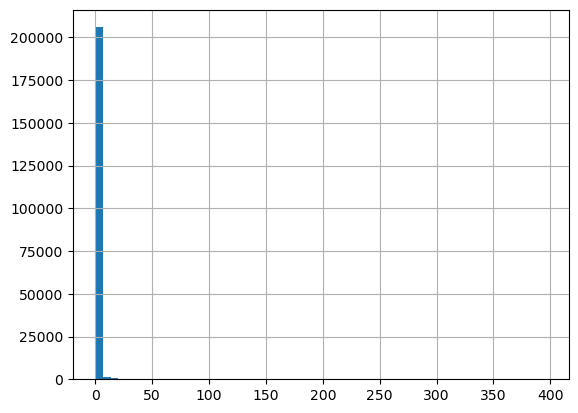

In [38]:
((df["timestamp"]-df["t_start"])/pd.Timedelta("1 minute")).hist(bins=60)

Now we can add a meaningful `trial_duration` column, which will contain the duration of each trial as a timedelta, and remove the `t_start` and `t_delta` columns from the nosepokes dataset as they're now unnecessary.

In [39]:
df.insert(2, "trial_duration", df["timestamp"]-df["t_start"])
nosepokes_data = nosepokes_data.drop(columns = ["t_start", "t_delta"])

### Heatmap helper functions

And, finally, these are heatmap generator helper functions. They use Plotly and generate individual maps which can be scrolled through using a slider. The function also supports the specification of an additional column, the value of which will be visible when hovering over individual fields of a heatmap.

In [40]:
def create_hm(df: pd.DataFrame,
              time_column: str,
              data_column: str,
              data_aggfunc: str,
              datetime_start: pd.Timestamp | datetime.datetime,
              datetime_end: pd.Timestamp | datetime.datetime,
              resample_period: pd.Timedelta,
              time_of_day_start: datetime.time = None,
              time_of_day_end: datetime.time = None,
              metadata_column: str = None,
              metadata_column_aggfunc: str = None,
              fillna_columns: dict[str] = None,
              plot_name: str = "Heatmap",
              trace_name: str = None,
              transpose: bool = False,
              colorscale: str = None,
              values_as_percentages: bool = False) -> go.Heatmap:
    """
    Produce a heatmap from a DataFrame.
        - additional_columns_aggfunc: key - column name, value - function to use to aggregate said column, e.g. sum, mean, etc.
        - fillna_columns: key - column name, value - value to fill NaNs with. unlisted columns will not be filled.
        NOTE: This applies only to numeric columns. Object columns will be forward-filled, and then back-filled.
    """
    if metadata_column and not metadata_column_aggfunc:
        raise ValueError("If metadata_column is specified, metadata_column_aggfunc must also be specified.")
    aggfunc = {data_column: data_aggfunc}
    if metadata_column:
        aggfunc[metadata_column] = metadata_column_aggfunc
    datetime_start = datetime_start.floor(pd.to_timedelta(resample_period))
    datetime_end = datetime_end.ceil(pd.to_timedelta(resample_period))
    time_range = pd.date_range(start=datetime_start,#.floor(pd.to_timedelta(resample_period)),
                               end=datetime_end,#.ceil(pd.to_timedelta(resample_period)),
                               freq=resample_period)
    if time_of_day_start or time_of_day_end:
        if not time_of_day_start:
            time_of_day_start = datetime.time(0, 0, 0)
        if not time_of_day_end:
            time_of_day_end = datetime.time(23, 59, 59)
        time_range = time_range[time_range.indexer_between_time(start_time=time_of_day_start, end_time=time_of_day_end)]

    if metadata_column:
        df = df[[time_column, data_column, metadata_column]].copy()
    else:
        df = df[[time_column, data_column]].copy()
    df = df.set_index(time_column)
    df = df.loc[(df.index > datetime_start) & (df.index < datetime_end)].copy()
    df = df.resample(resample_period,
                     origin=datetime_start#.floor(pd.to_timedelta(resample_period))
                     ).aggregate(aggfunc)
    df = df.convert_dtypes()
    
    if metadata_column:
        if df[metadata_column].dtype == "string":
            df[metadata_column] = df[metadata_column].ffill().bfill()
    if fillna_columns:
        for col, value in fillna_columns.items():
            df[col] = df[col].fillna(value)
    df = df.reindex(time_range, fill_value=0)
    df = df.reset_index(names="_timestamp")
    
    #df["_time"] = df["_timestamp"].dt.strftime("%H:%M")
    #df["_date"] = df["_timestamp"].dt.date
    
    df["_time"] = df["_timestamp"].apply(lambda x: pd.to_datetime(datetime.datetime.combine(pd.Timestamp(0), x.time())))
    df["_date"] = pd.to_datetime(df["_timestamp"].dt.normalize())
    if time_of_day_start and time_of_day_end:
        if time_of_day_start > time_of_day_end:
            nonshifted_time = df["_time"].copy()
            df.loc[nonshifted_time < datetime.datetime.combine(pd.Timestamp(0), time_of_day_start), "_time"] += pd.Timedelta("1 day")
            df.loc[nonshifted_time < datetime.datetime.combine(pd.Timestamp(0), time_of_day_start), "_date"] -= pd.Timedelta("1 day")
    
    #df = df.drop(columns=["_timestamp"])
    if transpose:
        columns = "_time"
        xhoverformat = "%H:%M"
        index = "_date"
        yhoverformat = "%Y-%m-%d"
    else:
        columns = "_date"
        xhoverformat = "%Y-%m-%d"
        index = "_time"
        yhoverformat = "%H:%M"
    
    values = [data_column, "_timestamp"]
    if metadata_column:
        values += [metadata_column]
    aggfunc["_timestamp"] = "first"
    heat_df = df.pivot_table(
        index=index,
        columns=columns,
        values=values,
        dropna=False,
        sort=True,
        aggfunc=aggfunc
    )
    # Convert to float as Plotly cannot draw Pandas NAs, which are integers,
    # but can draw with NumPy NaNs which are floats. The conversion automatically converts
    # Pandas NAs to NumPy NaNs.
    heat_df[data_column] = heat_df[data_column].astype("float")
    if metadata_column:
        if all([pd.api.types.is_numeric_dtype(x) for x in heat_df[metadata_column].dtypes]):
            heat_df[metadata_column] = heat_df[metadata_column].astype("float")
    #heat_df["_timestamp"] = heat_df["_timestamp"].astype("datetime64[ns]")
    hovertemplate = ("Timestamp: %{customdata[0]}<br>"+
                     data_column + ": %{z}<br>")
    if metadata_column:
        hovertemplate += (metadata_column + ": %{customdata[1]}<br>")

    #hm = go.Heatmap(z=heat_df.values,
    #                x=heat_df.columns,
    #                y=[x.isoformat() for x in heat_df.index],

    if not trace_name:
        trace_name = data_column
    
    if values_as_percentages:
        zhoverformat = ".2%"
    else:
        zhoverformat = None

    hm = go.Heatmap(#heat_df[data_column],
                    x=heat_df[data_column].columns, #_time
                    y=heat_df[data_column].index, #_date
                    z=heat_df[data_column].values,
                    #transpose=transpose
                    #zmin=heat_data_animal.values, zmax=mirovals["miro_value"].max(), #zmax=np.ceil(freq_td/display_unit_td),
                    #zmin=animal_zmin, zmax=animal_zmax,
                    #zauto=False,
                    #xgap=0, ygap=0,
                    #name=f"{sensor} sensor",
                    #colorscale="Brwnyl")
                    #color_continuous_scale="Brwnyl")
                    xhoverformat=xhoverformat,
                    yhoverformat=yhoverformat,
                    zhoverformat=zhoverformat,
                    colorscale=colorscale
    )
                    #colorbar=dict(ticksuffix=f" {display_unit}")
    #hm.update_coloraxes(colorbar_title = data_column)
    #fig_hm = go.FigureWidget(hm)
    # if transpose:
    #     metadata = heat_df[metadata_column].T
    # else:
    #     metadata = heat_df[metadata_column]
    
    metadata = [heat_df["_timestamp"].apply(lambda x: x.dt.strftime("%Y-%m-%d %H:%M:%S"))]
    if metadata_column:
        metadata.append(heat_df[metadata_column])
    metadata = np.stack(metadata, axis=-1)
    
    #metadata = np.zeros(heat_df["_timestamp"].shape, dtype=[('_timestamp', 'datetime64[ns]'), (metadata_column, 'int')])

    # Populate the structured array
    #metadata['_timestamp'] = heat_df["_timestamp"].values
    #metadata[metadata_column] = heat_df[metadata_column].values
    hm.update(name = trace_name, customdata = metadata, hovertemplate = hovertemplate)
    #else:
        #hm.update(name = trace_name, hovertemplate = hovertemplate)
    #fig_hm.layout.title = plot_name
    return hm

def update_hm(fig, plot_index, hm_dict, title=None, group_dict=None, device_dict=None, autoscale=True, zmin=None, zmax=None):
    plot_indexes = list(hm_dict.keys())
    animal = plot_indexes[plot_index]
    data = hm_dict[animal]
    fig.update_traces(hm_dict[animal])
    if not autoscale:
        if not zmin and not zmax:
            ValueError("If autoscale is False, zmin and zmax must be specified.")
        else:
            fig.update_traces(zmin=zmin, zmax=zmax, zauto=False)
    if title:
        # if group_dict:
        #     fig.update_layout(title=title.format(animal=animal, group=group_dict[animal]))
        # if device_dict:
        fig.update_layout(title=title.format(animal=animal, group=group_dict[animal], device_id=device_dict[animal]))
        # else:
        #     fig.update_layout(title=title.format(animal=animal))
    if IN_COLAB:
        fig.show()

def create_all_hms(args: dict) -> dict[go.Heatmap]:
    df = args["df"]
    args = args.copy()
    del(args["df"])
    hm_dict = {}

    if ("datetime_start" not in args) or (not args["datetime_start"]):
        args["datetime_start"] = df[args["time_column"]].min()
    if ("datetime_end" not in args) or (not args["datetime_end"]):
        args["datetime_end"] = df[args["time_column"]].max()
    if ("plot_name" not in args) or (not args["plot_name"]):
        args["plot_name"] = "Heatmap"

    for animal in natsorted(df["animal"].unique()):
        group = df[df["animal"] == animal]["group"].unique()[0]
        #if "plot_name" not in args:
        #    plot_name = f"{group} - {animal}"
        hm = create_hm(df = df[df["animal"] == animal],
                       **args)
        hm_dict[animal] = hm

    return hm_dict

def get_bounds(hm_dict: dict[go.Heatmap],
               fig_params: dict) -> dict:
    bounds = {}
    if not fig_params["autoscale"]:
        bounds["zmax"] = np.nanmax([np.nanmax(hm.z) for hm in hm_dict.values()])
        bounds["zmin"] = np.nanmin([np.nanmin(hm.z) for hm in hm_dict.values()])
        bounds["datemin"] = np.nanmin([np.nanmin(hm.x) for hm in hm_dict.values()])
        bounds["datemax"] = np.nanmax([np.nanmax(hm.x) for hm in hm_dict.values()])
        bounds["timemin"] = np.nanmin([np.nanmin(hm.y) for hm in hm_dict.values()])
        bounds["timemax"] = np.nanmax([np.nanmax(hm.y) for hm in hm_dict.values()])
    else:
        bounds["zmin"] = None
        bounds["zmax"] = None
    return bounds

def fig_setup(fig: go.FigureWidget,
              fig_params: dict,
              plot_params: dict):
    if plot_params["transpose"]:
        fig.update_xaxes(**fig_params["time_format"])
        fig.update_yaxes(**fig_params["date_format"])
    else:
        fig.update_xaxes(**fig_params["date_format"])
        fig.update_yaxes(**fig_params["time_format"])
    return

def draw_plot(plot_params: dict,
              fig_params: dict,
              group_dict: dict = None,
              device_dict: dict = None):
    plots = create_all_hms(plot_params)
    bounds = get_bounds(plots, fig_params)

    fig = go.FigureWidget(go.Heatmap())
    if "plot_name" not in plot_params:
        plot_params["plot_name"] = "Heatmap"
    if (
        (("time_of_day_start" in plot_params) and plot_params["time_of_day_start"])
        and
        (("time_of_day_end" in plot_params) and plot_params["time_of_day_end"])
    ):
        if plot_params["time_of_day_start"] > plot_params["time_of_day_end"]:
            fig_params["range"] = [datetime.datetime.combine(pd.Timestamp(0),
                                                             plot_params["time_of_day_start"]).isoformat(),
                                   datetime.datetime.combine(pd.Timestamp(0)+pd.Timedelta("1 day"),
                                                             plot_params["time_of_day_start"]).isoformat()]
    fig_setup(fig, fig_params, plot_params)
    if ("values_as_percentages" in plot_params) and plot_params["values_as_percentages"]:
        #fig.update_coloraxes(colorbar_tickformat=".0%")
        fig.update_traces(colorbar_tickformat=".0%")

    # for title, `update_hm` understands `{animal}`, `{group}`, and `{device_id}` as placeholders.
    # `animal` is gotten from the key of `hm_dict`, and `group` is gotten from the `group_dict` dictionary, for which we pass `map_animal_group`.
    update_this_plot = lambda plot_index: update_hm(fig, plot_index-1,
                                                    hm_dict = plots,
                                                    title = plot_params["plot_name"],
                                                    group_dict = group_dict,
                                                    device_dict = device_dict,
                                                    autoscale = fig_params["autoscale"],
                                                    zmin = bounds["zmin"],
                                                    zmax = bounds["zmax"])
    if len(plots) == 0:
        raise ValueError("No plots to show.")
    if IN_COLAB:
        slider = widgets.IntSlider(value=1, min=1, max=len(plots), step=1, description="Plot index")
        w = widgets.interactive(update_this_plot, plot_index=slider)
        display(w)
    else:
        # Create the slider and show it
        slider = widgets.IntSlider(value=1, min=1, max=len(plots), step=1, description="Plot index")
        display(slider)
        # Link the slider to the update function
        widgets.interactive(update_this_plot, plot_index=slider)
        # Show the plot
        display(fig)
    return (fig, plots)

---

## Exploration - Heatmaps

Heatmaps are a useful way of visualising time series data. By generating one for each animal, we can scroll through them and get a feeling of what happened, while also taking note of peculiarities that might have occurred in individual animals. The idea is to be able to quickly screen a lot of data before taking group summary statistics (from pure means to complex statistical models).

We'll start off with a detailed example which showcases what we can do with these functions, and move on to other interesting variables. The first example will be more verbose and documented to showcase the heatmap functionality at our disposal.

### Number of initiated trials

First, we'll examine the number of initiated trials throughout the experimental period. We do this to check if all animals have actually been interacting with the device. If not, we can remove these from the dataset and analyse the remainder. It's good to view these heatmaps along with the experimental notebook which should contain data if and when failures and malfunctions occurred so the heatmaps are more informative. 

The following `plot_params` dictionary contains parameters that specify how the data is processed and shown on a heatmap.

- `df` - Pandas dataframe containing all data to be included in the heatmap.
- `time_column` - Name of the column containing the timestamps.
- `data_column` - Name of the column containing the values to be plotted.
- `data_aggfunc` - Which function to use to aggregate data into bins/heatmap fields (e.g. sum, mean...).
- `datetime_start` - Timestamp of the start of the heatmap's time span.
- `datetime_end` - Timestamp of the end of the heatmap's time span.
- `resample_period` - The period each heatmap field spans (i.e. width of the resampling bin).
- `time_of_day_start` - Optional: Start point of each day (default = `None`, each day starts from 00:00)
- `time_of_day_end` - Optional: End point of each day (default = `None`, each day ends at 23:59:59)
- `metadata_column` - Optional: Name of column containing additional data to be added to the hover menu of heatmap fields.
- `metadata_column_aggfunc` - Optional: Which function to use to aggregate the additional data into bins/heatmap fields.
- `fillna_columns` - Optional: A dictionary where the key contains the column name, and the value contains the name of the function to use to fill NA values. (default: `None` - Do not fill NA values)
- `plot_name` - Optional: The name/title of the plot. (default: "Heatmap")
- `trace_name` - Optional: The name/title of the trace, which will be shown on mouse hover over the fields. (default: same as the name of the data column)
- `transpose` - Optional: Whether to switch x and y axes. (default: False)
- `colorscale` - Optional: Which colours to use. A list of available colorscales [can be found here](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Heatmap.html). (default: Plotly's default colour scale for heatmaps.)
- `values_as_percentages` - Optional: If True, values on hover and in the colour scale will be shown as percentages. (default: False)


In this example, we will use the `df_test` dataframe, show the number of initiated trials, and add the number of correctly solved trials in the hover menu.

In [41]:
plot_params_tr_easy = {
    "df": df.loc[(df["reliability"] == 1) & ### Remove the pound sign at the beginning of the line
                                             ### to exclude data we've deemed unreliable.
                 (df["protocol"] == "training") &
                 (df["difficulty"] == "easy")],
    "resample_period": pd.to_timedelta("15 minutes"),
    "time_column": "t_start",
    "data_column": "correct",
    "data_aggfunc": "sum",
    "time_of_day_start": datetime.time(19, 0),
    "time_of_day_end": datetime.time(1, 0),
    #"metadata_column": "correct",
    #"metadata_column_aggfunc": "sum",
    #"fillna_columns": {"correct": 0},
    "plot_name" : "Training, easy: {group} - {animal} ({device_id})",
    "transpose": False
}
plot_params_tr_diff = plot_params_tr_easy.copy()
plot_params_tr_diff["df"] = df.loc[(df["reliability"] == 1) &
                                   (df["protocol"] == "training") &
                                   (df["difficulty"] == "difficult")]
plot_params_tr_diff["plot_name"] = "Training, difficult: {group} - {animal} ({device_id})"

plot_params_tst_easy = {
    "df": df.loc[(df["reliability"] == 1) &
                 (df["protocol"] == "test") &
                 (df["difficulty"] == "easy")],
    "resample_period": pd.to_timedelta("15 minutes"),
    "time_column": "timestamp",
    "data_column": "precue_correct",
    "data_aggfunc": "sum",
    #"datetime_start": pd.to_datetime("2023-03-01 19:00:00"),
    #"datetime_end": pd.to_datetime("2023-03-28 23:59:00"),
    "time_of_day_start": datetime.time(19, 0),
    "time_of_day_end": datetime.time(23, 0),
    "metadata_column": "correct",
    "metadata_column_aggfunc": "sum",
    "fillna_columns": {"precue_correct": 0,
                       "correct": 0},
    "plot_name" : "Test, easy: {group} - {animal} ({device_id})",
    "transpose": False
}
plot_params_tst_diff = plot_params_tst_easy.copy()
plot_params_tst_diff["df"] = df.loc[(df["reliability"] == 1) &
                                    (df["protocol"] == "test") &
                                    (df["difficulty"] == "difficult")]
plot_params_tst_diff["time_of_day_end"] = datetime.time(23, 0)
plot_params_tst_diff["plot_name"] = "Test, difficult: {group} - {animal} ({device_id})"


The following `fig_params` dictionary specifies figure formatting options.

* `autoscale` specifies whether to autoscale each plot (useful for seeing colour changes in animals with small values), or use the same colour scale range for all plots (useful for comparing animals' heatmaps)

* `date_format` and `time_format` and formatting options for the date and time axes, respectively (either of which may be x or y, depending on the `transpose` parameter in `plot_params` - the code figures out which is which on its own). The formatting options are passed to [`fig.update_yaxes`](https://plotly.com/python/reference/layout/yaxis/) or [`fig.update_xaxes`](https://plotly.com/python/reference/layout/xaxis/). The linked Plotly docs contain more supported formatting options for the axes.

In [42]:
fig_params = {
    "autoscale": True,
    "date_format": {
        "tickformat": "%Y-%m-%d",
        "tickangle": -30,
        "dtick": pd.Timedelta("1 day").total_seconds()*1000,
    },
    "time_format": {
        "tickformat": "%H:%M",
        #"dtick": pd.Timedelta("30 minutes").total_seconds()*1000,
    }
}

Finally, we use all of the above to generate and show the heatmaps.

#### Training period

In [43]:
fig, plots = draw_plot(plot_params_tr_easy, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'customdata': array([[['2023-02-15 19:00:00'],
                                    ['2023-02-16 19:00:00'],
                                    ['2023-02-17 19:00:00'],
                                    ['2023-02-18 19:00:00']],
                            
                                   [['2023-02-15 19:15:00'],
                                    ['2023-02-16 19:15:00'],
                                    ['2023-02-17 19:15:00'],
                                    ['2023-02-18 19:15:00']],
                            
                                   [['2023-02-15 19:30:00'],
                                    ['2023-02-16 19:30:00'],
                                    ['2023-02-17 19:30:00'],
                                    ['2023-02-18 19:30:00']],
                            
                                   [['2023-02-15 19:45:00'],
                                    ['2023-02-16 19:45:00'],
                                    ['202

In [44]:
fig, plots = draw_plot(plot_params_tr_diff, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'customdata': array([[['2023-02-19 19:00:00'],
                                    ['2023-02-20 19:00:00'],
                                    ['2023-02-21 19:00:00'],
                                    ...,
                                    ['2023-02-26 19:00:00'],
                                    ['2023-02-27 19:00:00'],
                                    ['2023-02-28 19:00:00']],
                            
                                   [['2023-02-19 19:15:00'],
                                    ['2023-02-20 19:15:00'],
                                    ['2023-02-21 19:15:00'],
                                    ...,
                                    ['2023-02-26 19:15:00'],
                                    ['2023-02-27 19:15:00'],
                                    ['2023-02-28 19:15:00']],
                            
                                   [['2023-02-19 19:30:00'],
                                    ['2023-02-20 1

#### Test period

In [45]:
fig_params["date_format"]["dtick"] = pd.Timedelta("1 day").total_seconds()*1000
fig, plots = draw_plot(plot_params_tst_easy, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'customdata': array([[['2023-03-01 19:00:00', 3.0],
                                    ['2023-03-02 19:00:00', 0.0],
                                    ['2023-03-03 19:00:00', 0.0],
                                    ...,
                                    ['2023-03-08 19:00:00', 1.0],
                                    ['2023-03-09 19:00:00', 3.0],
                                    ['2023-03-10 19:00:00', 0.0]],
                            
                                   [['2023-03-01 19:15:00', 3.0],
                                    ['2023-03-02 19:15:00', 0.0],
                                    ['2023-03-03 19:15:00', 0.0],
                                    ...,
                                    ['2023-03-08 19:15:00', 0.0],
                                    ['2023-03-09 19:15:00', 5.0],
                                    ['2023-03-10 19:15:00', 14.0]],
                            
                                   [['2023-03-01 1

In [46]:
fig, plots = draw_plot(plot_params_tst_diff, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'customdata': array([[['2023-03-11 19:00:00', 2.0],
                                    ['2023-03-12 19:00:00', 0.0],
                                    ['2023-03-13 19:00:00', 3.0],
                                    ...,
                                    ['2023-03-26 19:00:00', 0.0],
                                    ['2023-03-27 19:00:00', 0.0],
                                    ['2023-03-28 19:00:00', 0.0]],
                            
                                   [['2023-03-11 19:15:00', 0.0],
                                    ['2023-03-12 19:15:00', 0.0],
                                    ['2023-03-13 19:15:00', 0.0],
                                    ...,
                                    ['2023-03-26 19:15:00', 0.0],
                                    ['2023-03-27 19:15:00', 0.0],
                                    ['2023-03-28 19:15:00', 0.0]],
                            
                                   [['2023-03-11 19

We can see no interactions or weird patterns with some devices.

Practically complete failures, also listed in the lab notes:

- `vds_19` (`zeleni3`): complete failure (doesn't show up in the dataframe)
- `vds_5` (`crveni1`): complete failure
- `vds_37` (`crveni10`): complete failure
- `vds_15` (`zeleni6`): complete failure
- `vds_1` (`zeleni9`): complete failure
- `vds_13` (`crveni6`): only one day of registered interaction

We will set `reliability` to `0` for these animals/devices as well.

In [47]:
df.loc[df["device"].isin(faulty_devices),
       "reliability"] = 0

Some odd patterns or a few missing days:

- `vds_35` (`crveni3`): the last day is empty
- `vds_11` (`crveni4`): the last two days are empty
- `vds_27` (`crveni9`): some empty days in the middle of test-difficult
- `vds_9` (`crveni5`): test-difficult seems sparse - many empty days

The first two have nearly all of the data, which should still be usable. Let's examine further...

### Whether a session was performed each day

Usually, the devices will send a message when they finish "a day's work", even if the animal had no interactions with the device. We can check whether there were days when absolutely no message was sent as a further means of diagnostics. We won't look at the animals we've already removed based on lab notes or the previous heatmaps.

In [48]:
all_days = pd.Series(pd.date_range(start=pd.Timestamp("2023-02-15"), end=pd.Timestamp("2023-03-28"), freq=pd.Timedelta("1 day")))
device_days_deviceoff = {}
working_devices = set(df["device"].unique()) - set(faulty_devices)
for device in working_devices:
    device_days = pd.Series((df.loc[df["device"] == device, "t_start"].dt.date.unique()).astype("datetime64[ns]"))
    device_off = all_days.loc[~all_days.isin(device_days)]
    if not device_off.empty:
        device_days_deviceoff[device] = device_off.copy()
pd.DataFrame(device_days_deviceoff)

,vds_27,vds_3,vds_7,vds_9,vds_35,vds_11
17,NaT,NaT,2023-03-04,NaT,NaT,NaT
25,2023-03-12,NaT,NaT,NaT,NaT,NaT
28,NaT,NaT,NaT,2023-03-15,NaT,NaT
29,NaT,NaT,NaT,2023-03-16,NaT,NaT
30,2023-03-17,NaT,NaT,NaT,NaT,NaT
31,2023-03-18,NaT,NaT,NaT,NaT,NaT
33,NaT,NaT,2023-03-20,NaT,NaT,NaT
35,NaT,2023-03-22,NaT,NaT,NaT,NaT
38,NaT,NaT,NaT,2023-03-25,NaT,NaT
39,NaT,NaT,NaT,2023-03-26,NaT,NaT


There were a few days in a few of the animals when this happened, during the more difficult stage of the testing period. We have to be careful when analysing this part. We'll set `reliability` to `0` for these animals from the first faulty day until the end of the experiment. Since `vds_7` generally seems to have okay data, and it's only one day during the easy and difficult testing periods missing, this step would remove virtually all of its data. We'll leave it in for now.

In [49]:
del device_days_deviceoff["vds_7"]

for device, days in device_days_deviceoff.items():
    first_day = pd.to_datetime(
        datetime.datetime.combine(
            days.min().date(),
            datetime.time(12)
        )
    )
    df.loc[(df["device"] == device) &
           (df["t_start"] > first_day),
           "reliability"] = 0

### Nosepokes over the whole experimental period

In [50]:
nosepokes_data

,state,msg_timestamp,animal
index,,,
0,INTVL:IDLE,2023-02-04 17:09:46.327098,zeleni1
1,POINT:CUE,2023-02-04 18:24:50.885239,zeleni1
2,POINT:CUE,2023-02-04 19:01:03.044178,zeleni1
3,POINT:CUE,2023-02-04 20:24:54.034800,zeleni1
4,POINT:CUE,2023-02-04 20:25:30.875863,zeleni1
...,...,...,...
173269,INTVL:IDLE,2023-03-29 04:08:23.848315,crveni9
173270,INTVL:IDLE,2023-03-29 04:29:31.961806,crveni9
173271,INTVL:IDLE,2023-03-29 04:29:32.954395,crveni9


In [51]:
nosepokes_data = nosepokes_data.pivot_table(index=["msg_timestamp","animal"], columns='state', aggfunc='size').reset_index().fillna(0)
nosepoke_event_types = list(set(nosepokes_data.columns)-set(["msg_timestamp", "animal"]))
nosepokes_data["all_nosepokes"] = nosepokes_data[nosepoke_event_types].sum(axis=1)
nosepokes_data["group"] = nosepokes_data["animal"].apply(lambda x: map_animal_group[x])
nosepokes_data["device"] = nosepokes_data["animal"].apply(lambda x: map_animal_device[x])

In [52]:
plot_params_np = {
    "df": nosepokes_data,
    "resample_period": pd.to_timedelta("60 minutes"),
    "time_column": "msg_timestamp",
    "data_column": "all_nosepokes",
    "data_aggfunc": "sum",
    #"time_of_day_start": datetime.time(19, 0),
    #"time_of_day_end": datetime.time(22, 0),
    #"metadata_column": "precue_correct",
    #"metadata_column_aggfunc": "sum",
    "plot_name" : "Nosepokes: {group} - {animal} ({device_id})",
    "transpose": False,
    #"values_as_percentages": True
}
fig_params["autoscale"] = True

In [53]:
fig_params["date_format"]["dtick"] = pd.Timedelta("3 days").total_seconds()*1000
fig, plots = draw_plot(plot_params_np, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=19, min=1)

FigureWidget({
    'data': [{'customdata': array([[[nan],
                                    ['2023-02-05 00:00:00'],
                                    ['2023-02-06 00:00:00'],
                                    ...,
                                    ['2023-03-27 00:00:00'],
                                    ['2023-03-28 00:00:00'],
                                    ['2023-03-29 00:00:00']],
                            
                                   [[nan],
                                    ['2023-02-05 01:00:00'],
                                    ['2023-02-06 01:00:00'],
                                    ...,
                                    ['2023-03-27 01:00:00'],
                                    ['2023-03-28 01:00:00'],
                                    ['2023-03-29 01:00:00']],
                            
                                   [[nan],
                                    ['2023-02-05 02:00:00'],
                                    ['2023-

We can also exclude the period while VLADISLAV protocols were engaged, as these periods will naturally (hopefully) have more nosepokes than when the device is idle (with free access to water and no light stimuli) and skew the heatmap scale towards higher values.

In [54]:
plot_params_np["time_of_day_start"] = datetime.time(1, 0)
plot_params_np["time_of_day_end"] = datetime.time(19, 0)
fig, plots = draw_plot(plot_params_np, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=19, min=1)

FigureWidget({
    'data': [{'customdata': array([[[nan],
                                    ['2023-02-05 01:00:00'],
                                    ['2023-02-06 01:00:00'],
                                    ...,
                                    ['2023-03-27 01:00:00'],
                                    ['2023-03-28 01:00:00'],
                                    ['2023-03-29 01:00:00']],
                            
                                   [[nan],
                                    ['2023-02-05 02:00:00'],
                                    ['2023-02-06 02:00:00'],
                                    ...,
                                    ['2023-03-27 02:00:00'],
                                    ['2023-03-28 02:00:00'],
                                    ['2023-03-29 02:00:00']],
                            
                                   [['2023-02-04 03:00:00'],
                                    ['2023-02-05 03:00:00'],
                         

This is interesting in its own right, but we know it's impossible to have one nosepoke each second for hours or days at a time. We'll show all days where we have a nosepoke count of over 500 in an hour in animals we haven't already listed in `faulty_devices`.

In [55]:
nosepokes_data["device"] = nosepokes_data["animal"].apply(lambda x: map_animal_device[x])
nosepokes_data_hourly = (
    nosepokes_data[["msg_timestamp", "device", "all_nosepokes"]]
    .set_index("msg_timestamp")
    .groupby("device", group_keys = False)
    .resample(pd.to_timedelta("1 hour"))
    .aggregate({"all_nosepokes": "sum",
                "device": "first"})
)
nosepokes_data_dailymax = (
    nosepokes_data_hourly
    .groupby("device", group_keys = False)
    .resample(pd.to_timedelta("1 day"))
    .aggregate({"all_nosepokes": "max",
                "device": "first"})
)
nosepokes_data_dailymax = (
    pd.DataFrame(
        nosepokes_data_dailymax.loc[
            nosepokes_data_dailymax["all_nosepokes"] > 500
        ]["device"]
    ).reset_index()
    .pivot(index="msg_timestamp",
           columns="device",
           values="msg_timestamp")
)
nosepokes_data_dailymax[list(
    set(nosepokes_data_dailymax.columns) - set(faulty_devices)
)]

device,vds_9,vds_31,vds_11,vds_27
msg_timestamp,,,,
2023-02-06,NaT,NaT,NaT,NaT
2023-02-27,NaT,NaT,NaT,NaT
2023-02-28,NaT,2023-02-28,NaT,NaT
2023-03-01,NaT,NaT,NaT,NaT
2023-03-02,2023-03-02,NaT,NaT,NaT
2023-03-03,2023-03-03,NaT,NaT,NaT
2023-03-04,2023-03-04,NaT,NaT,NaT
2023-03-05,NaT,NaT,NaT,NaT
2023-03-06,NaT,NaT,NaT,NaT


During the easy testing protocol (1st to 10th March), `vds_11` and `vds_31` have a few problematic hours during the day, likely manual interventions during which the nosepoke opening got disconnected, but this is unlikely to have affected the actual device operation later in the day. 

`vds_11`, `vds_37`, and `vds_27` have a lot of problematic days during the difficult testing protocol (11th to 28th March), especially in the beginning (which would affect later days), so we'll set `reliability` to `0` for these animals for this entire period.

This is the case for the entire testing protocol period for `vds_9`, so we'll set `reliability` to `0` there as well.

In [56]:
df.loc[(df["device"].isin(["vds_11", "vds_37", "vds_27"])) &
       (df["protocol"] == "test") &
       (df["difficulty"] == "difficult"),
       "reliability"] = 0
df.loc[(df["device"].isin(["vds_9"])) &
       (df["protocol"] == "test"),
       "reliability"] = 0

We can now go back and enable `reliability` filtering to re-review the heatmaps only of the data we've deemed reliable enough to be included in subsequent analyses.

### Number of correctly solved trials

In [57]:
plot_params_tr_easy["resample_period"] = pd.to_timedelta("60 minutes")
plot_params_tr_easy["data_column"] = "correct"
plot_params_tr_easy["data_aggfunc"] = "mean"
plot_params_tr_easy["values_as_percentages"] = True

plot_params_tr_diff["resample_period"] = pd.to_timedelta("60 minutes")
plot_params_tr_diff["data_column"] = "correct"
plot_params_tr_diff["data_aggfunc"] = "mean"
plot_params_tr_diff["values_as_percentages"] = True

plot_params_tst_easy["resample_period"] = pd.to_timedelta("60 minutes")
plot_params_tst_easy["data_column"] = "correct"
plot_params_tst_easy["data_aggfunc"] = "mean"
plot_params_tst_easy["metadata_column"] = "precue_correct"
plot_params_tst_easy["metadata_column_aggfunc"] = "sum"
plot_params_tst_easy["values_as_percentages"] = True
del plot_params_tst_easy["fillna_columns"]

plot_params_tst_diff["resample_period"] = pd.to_timedelta("60 minutes")
plot_params_tst_diff["data_column"] = "correct"
plot_params_tst_diff["data_aggfunc"] = "mean"
plot_params_tst_diff["metadata_column"] = "precue_correct"
plot_params_tst_diff["metadata_column_aggfunc"] = "sum"
plot_params_tst_diff["values_as_percentages"] = True
del plot_params_tst_diff["fillna_columns"]


#### Training period

In [58]:
fig_params["date_format"]["dtick"] = pd.Timedelta("1 day").total_seconds()*1000
fig, plots = draw_plot(plot_params_tr_easy, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'colorbar': {'tickformat': '.0%'},
              'customdata': array([[['2023-02-15 19:00:00'],
                                    ['2023-02-16 19:00:00'],
                                    ['2023-02-17 19:00:00'],
                                    ['2023-02-18 19:00:00']],
                            
                                   [['2023-02-15 20:00:00'],
                                    ['2023-02-16 20:00:00'],
                                    ['2023-02-17 20:00:00'],
                                    ['2023-02-18 20:00:00']],
                            
                                   [['2023-02-15 21:00:00'],
                                    ['2023-02-16 21:00:00'],
                                    ['2023-02-17 21:00:00'],
                                    ['2023-02-18 21:00:00']],
                            
                                   [['2023-02-15 22:00:00'],
                                    ['2023-02-16 22:0

In [59]:
fig, plots = draw_plot(plot_params_tr_diff, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'colorbar': {'tickformat': '.0%'},
              'customdata': array([[['2023-02-19 19:00:00'],
                                    ['2023-02-20 19:00:00'],
                                    ['2023-02-21 19:00:00'],
                                    ['2023-02-22 19:00:00'],
                                    ['2023-02-23 19:00:00'],
                                    ['2023-02-24 19:00:00'],
                                    ['2023-02-25 19:00:00'],
                                    ['2023-02-26 19:00:00'],
                                    ['2023-02-27 19:00:00'],
                                    ['2023-02-28 19:00:00']],
                            
                                   [['2023-02-19 20:00:00'],
                                    ['2023-02-20 20:00:00'],
                                    ['2023-02-21 20:00:00'],
                                    ['2023-02-22 20:00:00'],
                                    ['2023-02-23 20:

#### Test period

In [60]:
fig, plots = draw_plot(plot_params_tst_easy, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'colorbar': {'tickformat': '.0%'},
              'customdata': array([[['2023-03-01 19:00:00', 13.0],
                                    ['2023-03-02 19:00:00', 2.0],
                                    ['2023-03-03 19:00:00', 0.0],
                                    ['2023-03-04 19:00:00', 7.0],
                                    ['2023-03-05 19:00:00', 23.0],
                                    ['2023-03-06 19:00:00', 12.0],
                                    ['2023-03-07 19:00:00', 23.0],
                                    ['2023-03-08 19:00:00', 6.0],
                                    ['2023-03-09 19:00:00', 10.0],
                                    ['2023-03-10 19:00:00', 22.0]],
                            
                                   [['2023-03-01 20:00:00', 4.0],
                                    ['2023-03-02 20:00:00', 3.0],
                                    ['2023-03-03 20:00:00', 5.0],
                                    ['2023

In [61]:
fig, plots = draw_plot(plot_params_tst_diff, fig_params, map_animal_group, map_animal_device)

IntSlider(value=1, description='Plot index', max=14, min=1)

FigureWidget({
    'data': [{'colorbar': {'tickformat': '.0%'},
              'customdata': array([[['2023-03-11 19:00:00', 6.0],
                                    ['2023-03-12 19:00:00', 26.0],
                                    ['2023-03-13 19:00:00', 4.0],
                                    ['2023-03-14 19:00:00', 18.0],
                                    ['2023-03-15 19:00:00', 6.0],
                                    ['2023-03-16 19:00:00', 6.0],
                                    ['2023-03-17 19:00:00', 7.0],
                                    ['2023-03-18 19:00:00', 22.0],
                                    ['2023-03-19 19:00:00', 15.0],
                                    ['2023-03-20 19:00:00', 3.0],
                                    ['2023-03-21 19:00:00', 17.0],
                                    ['2023-03-22 19:00:00', 8.0],
                                    ['2023-03-23 19:00:00', 5.0],
                                    ['2023-03-24 19:00:00', 20.0],
      

---

## Saving the datasets

Finally, we will save the datasets to Parquet files for further analysis. We will save the trials dataframe as is (`df`), and we'll create `df_nosepokes` by resampling `nosepokes_data` to 1-minute bins to have a fixed sampling rate.

In [62]:
np_numerical_cols = list(set(nosepokes_data.columns)-set(["msg_timestamp", "animal", "group", "device"]))
np_aggfunctions = { col: "sum" for col in np_numerical_cols }
np_aggfunctions["device"] = "first"
np_aggfunctions["group"] = "first"
np_aggfunctions["animal"] = "first"
df_nosepokes = (
    nosepokes_data
    .set_index("msg_timestamp")
    .groupby("animal", group_keys=False)
    .resample(pd.to_timedelta("1 minute"))
    .aggregate(np_aggfunctions)
    .reset_index()
)
df_nosepokes.to_parquet(wd/f"vladislav_{experiment}_nosepokes.parquet")

df["extension_happened"] = (df["iti_extension"] > 0).astype(int)
df = df.reset_index(drop = True)
df.to_parquet(wd/f"vladislav_{experiment}_trials.parquet")

In [63]:
df_day = df[["t_start",
             "day",
             "animal",
             "group",
             "bhv",
             "bhv_performed",
             "reliability",
             "completion",
             "protocol",
             "difficulty",
             "session_part",
             "delay_precue_cue",
             "iti_extension",
             "extension_happened",
             "precue_correct",
             "impulsive_nosepokes",
             "correct",
             "reaction_time"]].copy()
df_day.loc[df_day["session_part"].isna(), "session_part"] = 0
aggfunctions = {
    "day": "last",
    "animal": "first",
    "group": "first",
    "bhv": "first",
    "bhv_performed": "first",
    "completion": "sum",
    "protocol": "first",
    "difficulty": "first",
    "session_part": "first",
    "delay_precue_cue": "mean",
    "iti_extension": "sum",
    "extension_happened": "sum",
    "precue_correct": "sum",
    "impulsive_nosepokes": "sum",
    "correct": "sum",
    "reaction_time": "mean"
}
df_day = ( df_day.loc[df_day["reliability"] == 1]
          .set_index("t_start")
          .groupby(["animal", "session_part"], group_keys=False)
          .resample(pd.to_timedelta("1 day"), origin=datetime.datetime.combine(
              df_day["t_start"].min().date(),
              datetime.time(12,0)
          ))
          .aggregate(aggfunctions)
)
df_day = df_day.loc[df_day["animal"].notna()].copy()

sess_overall_aggfunctions = aggfunctions.copy()
del sess_overall_aggfunctions["session_part"]
sess_overall_aggfunctions["t_start"] = "first"
df_day_sess_overall = df_day.reset_index().drop(columns="session_part").groupby(["t_start", "animal"], as_index=False).aggregate(sess_overall_aggfunctions).set_index("t_start")
df_day_sess_overall["session_part"] = "overall"
df_day["session_part"] = df_day["session_part"].astype("int").astype("string")
df_day = pd.concat([df_day, df_day_sess_overall])
df_day.to_parquet(wd/f"vladislav_{experiment}_trials_daybin.parquet")